In [ ]:
#try:
#    import sentencepiece as spm
#except ImportError as e:
#    os.system('pip install sentencepiece')
#    import sentencepiece as spm

In [ ]:
# Set the random seeds for reproducability.
SEED = 2020
#SEED = 2021
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# DEFINITIONS

In [ ]:
class Subword():
    def __init__(self, lang, vocab_size):
        """
        recomended: vocab_size = 2000 for lang = vi, 4000 for lang = ru
        """
        self.lang = lang
        self.vocab_size = vocab_size
        spm.SentencePieceTrainer.Train(f'--input=train.{lang} --model_prefix=vi --vocab_size={vocab_size} --model_type=unigram --character_coverage=1.0')
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(f"{lang}.model")
        
    def split_words(self, filename, new_filename):
        content = open(filename, 'r').read().splitlines()
        new_content = [' '.join(self.sp.EncodeAsPieces(line)) for line in content]
        open(new_filename, 'w').write('\n'.join(new_content))

    @staticmethod
    def join_pieces(pred_trgs, new_filename, type='bpe'):
        """
        function joins pieces to form words
        input: pred_trgs, list of list of pieces
        input: new_filename, str

        """
        lines = []
        if type == 'unigram':
            for line in pred_trgs:
                y = ''.join(line)
                y = y.replace('▁', ' ')
                lines.append(y)
        else:
            for line in pred_trgs:
                y = ' '.join(line)
                y = y.replace('@@ ','')
                lines.append(y)
        open(new_filename, 'w').write('\n'.join(lines))

## Data Center

Creating test.ru file

In [ ]:
dat = pd.read_csv('word.ru.tsv', sep='\t')
print(dat.columns)
dat.iloc[:1500,0].to_csv('test.ru', sep='\n', index=False, header=False)

In [ ]:
class DataCenter():

    def __init__(self, ru_token_type='unigram', vi_token_type='unigram', SELECTED = np.array([1, 1, 1, 0, 0, 1, 1, 1]), device='cuda'):
        """
        ru_token_type is one of {'unigram', 'bpe', 'word'}
        vi_token_type is one of {'unigram', 'bpe', 'syllable', 'word'}
        """
        self.SELECTED = SELECTED
        s = str(SELECTED)
        self.name = ru_token_type + s.replace(" ", "").replace("[","").replace("]","") + vi_token_type
        dat = pd.read_csv(f'{ru_token_type}.ru.tsv', sep='\t')
        ru_names = list(dat.columns)

        vi_data = pd.read_csv('new.vi.tsv', sep='\t')[vi_token_type]
        dat['vi'] = vi_data
        dat = dat[ru_names+['vi']]
        dat.iloc[:1500,:].to_csv('test.tsv', sep='\t', index=False, header=False)
        dat.iloc[1500:3000,:].to_csv('dev.tsv', sep='\t', index=False, header=False)
        dat.iloc[3000:,:].to_csv('train.tsv', sep='\t', index=False)

        self.device = device

        testfile, devfile, trainfile =  'test.tsv', 'dev.tsv', 'train.tsv'

        #The model expects data to be fed in with the batch dimension first, so we use `batch_first = True`. 
    
        field_names = list(pd.read_csv(trainfile,sep='\t').columns)

        self.field_sequence = [Field(tokenize = lambda x: x.split(' '), init_token = '<sos>', eos_token = '<eos>', lower = True, 
                        batch_first = True) for _ in field_names]
        
        fields = list(zip(field_names, self.field_sequence))

        self.mt_train = data.TabularDataset(
            path=trainfile, format='tsv',
            fields=fields)
        self.mt_dev = data.TabularDataset(
            path=devfile, format='tsv',
            fields=fields)
        self.mt_test = data.TabularDataset(
            path=testfile, format='tsv',
            fields=fields)
        
        for f in self.field_sequence:
            f.build_vocab(self.mt_train, min_freq = 2)
        
        self.SRC_PAD_IDX = self.field_sequence[0].vocab.stoi[self.field_sequence[0].pad_token]
        self.TRG_PAD_IDX = self.field_sequence[-1].vocab.stoi[self.field_sequence[-1].pad_token]
        self.src_lens = [len(field.vocab) for field in self.field_sequence[:-1]]
        self.trg_len = len(self.field_sequence[-1].vocab)

        # Finally, we define the device and the data iterator.
        self.train_iterator = data.BucketIterator(
            dataset=self.mt_train, batch_size=128,
            sort_key=lambda x: data.interleave_keys(len(x.ru), len(x.vi)), device = device)
        self.valid_iterator = data.BucketIterator(
            dataset=self.mt_dev, batch_size=128,
            sort_key=lambda x: data.interleave_keys(len(x.ru), len(x.vi)), device = device)
    
    @staticmethod
    def detokenize(ifilename, ofilename):
        findlines = '_'
        replacelines = ' '

        with open(ifilename,'r') as ifile, open(ofilename, 'w') as ofile:
            icontent = ifile.read()
            ocontent = icontent.replace(findlines, replacelines)
            ofile.write(ocontent)


In [ ]:
def detokenize(ifilename, ofilename):
	findlines = '_'
	replacelines = ' '

	with open(ifilename,'r') as ifile, open(ofilename, 'w') as ofile:
		icontent = ifile.read()
		ocontent = icontent.replace(findlines, replacelines)
		ofile.write(ocontent)

In [ ]:
def prepare_mt_datasets(trainfile, devfile, testfile):
    #The model expects data to be fed in with the batch dimension first, so we use `batch_first = True`. 
    
    field_names = list(pd.read_csv(trainfile,sep='\t').columns)

    field_sequence = [Field(init_token = '<sos>', eos_token = '<eos>', lower = True, 
                    batch_first = True) for _ in field_names]
    
    fields = list(zip(field_names,field_sequence))

    mt_train = data.TabularDataset(
        path=trainfile, format='tsv',
        fields=fields)
    mt_dev = data.TabularDataset(
        path=devfile, format='tsv',
        fields=fields)
    mt_test = data.TabularDataset(
        path=testfile, format='tsv',
        fields=fields)
    
    for f in field_sequence:
        f.build_vocab(mt_train, min_freq = 2)

    return field_sequence, mt_train, mt_dev, mt_test

## Transformer Model

### Encoder

In [ ]:
class Encoder(nn.Module):
    """
    this is an encoder incorporating input features
    """
    def __init__(self,
                 input_dims, selected, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        #[subtag', 'le', 'ihead', 'head', 'deprel', 'upos', 'feats']

        sizes = [190, 22, 22, 22]
        temp = []
        j = 0
        for i,se in enumerate(selected):
            if se:
                temp.append(nn.Embedding(input_dims[i], sizes[j]))
                j += 1
        self.embeddings = nn.ModuleList(temp)
        
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, s, src_mask):
        
        #src = [features, batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src[0].shape[0]
        src_len = src[0].shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        selected_ifeatures = []
        j = 0
        for i,se in enumerate(s):
            if se:
                selected_ifeatures.append(self.embeddings[j](src[i]))
                j += 1
                
        #pos = [batch size, src len]
        src = torch.cat(selected_ifeatures, dim=2)
        #src = [batch size, src len, aggregate_input_dim]
        #src = [batch size, src len, hid dim]
        
        src = self.dropout((src * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

### Encoder Layer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Mutli Head Attention Layer

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward Layer

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Decoder Layer

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(3)
        
        #trg_pad_mask = [batch size, 1, trg len, 1]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, s, trg):
        
        #src = [features, batch size, src len]
        #lmm = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src[0])
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, s, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Translation Model

In [ ]:
class TranslationModel():
    """
    Example usage:
    model = TranslationModel(src_lens, SELECTED,len(fields[-1].vocab),
                                         SRC_PAD_IDX, TRG_PAD_IDX)
    
    print(model.count_parameters())
    model.optimize_parameters(train_iterator, valid_iterator, N_EPOCHS=15)
    model.model.load_state_dict(checkpoint['state_dict'])
    _, _, pred_trgs = model.translate_dataset(mt_test[1:], fields)
    """

    def __init__(self,
                 data_center,
                 HID_DIM = 256,
                 ENC_LAYERS = 3,
                 DEC_LAYERS = 3,
                 ENC_HEADS = 8,
                 DEC_HEADS = 8,
                 ENC_PF_DIM = 512,
                 DEC_PF_DIM = 512,
                 ENC_DROPOUT = 0.1,
                 DEC_DROPOUT = 0.1,
                 device = 'cuda'):
        
        #self.name = f"{data_center.name}.{int(time.time())}.model"
        self.name = f"{data_center.name}.model"
        
        self.device = device

        self.TRG_PAD_IDX = data_center.TRG_PAD_IDX
        self.SELECTED = data_center.SELECTED
        enc = Encoder(data_center.src_lens, data_center.SELECTED,
                HID_DIM, 
                ENC_LAYERS, 
                ENC_HEADS, 
                ENC_PF_DIM, 
                ENC_DROPOUT, 
                device)

        dec = Decoder(data_center.trg_len, 
                    HID_DIM, 
                    DEC_LAYERS, 
                    DEC_HEADS, 
                    DEC_PF_DIM, 
                    DEC_DROPOUT, 
                    device)
        self.model = Seq2Seq(enc, dec, data_center.SRC_PAD_IDX, data_center.TRG_PAD_IDX, device).to(device)

        self.data_center = data_center

    
    def load_model(self, model_name=None):
        #Loading the best model
        if not model_name:
            checkpoint = torch.load(f'{self.name}.pt')
        else:
            checkpoint = torch.load(model_name)
        self.model.load_state_dict(checkpoint['state_dict'])
    
    
    # check the number of parameters
    def count_parameters(self):
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)
    

    def optimize_parameters(self, N_EPOCHS=20):
        
        train_iterator, valid_iterator = self.data_center.train_iterator, self.data_center.valid_iterator
        
        TRG_PAD_IDX = self.TRG_PAD_IDX
        model = self.model
        s = self.SELECTED
        def train_an_epoch(model, s, iterator, optimizer, criterion, clip):
        
            model.train()
            
            epoch_loss = 0
            
            for i, batch in enumerate(iterator):

                batch_dict = vars(batch)

                src = [batch_dict[feature] for feature in list(batch.fields)[:-1]]

                # if not(len(src[0][0])==len(src[1][0])==len(src[2][0])==len(src[3][0])==len(src[4][0])==len(src[5][0])==len(src[6][0])==len(src[7][0])):
                #     print(batch.ru) 
                
                trg = batch.vi
                
                optimizer.zero_grad()
                
                output, _ = model(src, s, trg[:,:-1])
                        
                #output = [batch size, trg len - 1, output dim]
                #trg = [batch size, trg len]
                    
                output_dim = output.shape[-1]
                    
                output = output.contiguous().view(-1, output_dim)
                trg = trg[:,1:].contiguous().view(-1)
                        
                #output = [batch size * trg len - 1, output dim]
                #trg = [batch size * trg len - 1]
                    
                loss = criterion(output, trg)
                
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                
                optimizer.step()
                
                epoch_loss += loss.item()
                
            return epoch_loss / len(iterator)
        
        
        def evaluate_an_epoch(model, s, iterator, criterion):
            
            model.eval()
            
            epoch_loss = 0
            
            with torch.no_grad():
            
                for i, batch in enumerate(iterator):

                    batch_dict = vars(batch)

                    src = [batch_dict[feature] for feature in list(batch.fields)[:-1]]
                    trg = batch.vi

                    output, _ = model(src, s, trg[:,:-1])
                    
                    #output = [batch size, trg len - 1, output dim]
                    #trg = [batch size, trg len]
                    
                    output_dim = output.shape[-1]
                    
                    output = output.contiguous().view(-1, output_dim)
                    trg = trg[:,1:].contiguous().view(-1)
                    
                    #output = [batch size * trg len - 1, output dim]
                    #trg = [batch size * trg len - 1]
                    
                    loss = criterion(output, trg)

                    epoch_loss += loss.item()
                
            return epoch_loss / len(iterator)
        

        #Xavier uniform seems to be common amongst Transformer models, so we use it here
        def initialize_weights(m):
            if hasattr(m, 'weight') and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight.data)
        
        
        model.apply(initialize_weights);
        # Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.
        LEARNING_RATE = 0.0005

        optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
        # Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.
        criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

        '''
        Finally, we train our actual model. This model is almost 3x faster than the 
        convolutional sequence-to-sequence model and also achieves 
        a lower validation perplexity!
        '''
        CLIP = 1
        epoch = 0

        best_valid_loss = float('inf')

        while epoch < N_EPOCHS:
            # print("Training %s-th epoch" % epoch)
            
            start_time = time.time()
            
            train_loss = train_an_epoch(model, s, train_iterator, optimizer, criterion, CLIP)
            valid_loss = evaluate_an_epoch(model, s, valid_iterator, criterion)
            
            end_time = time.time()
            
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)
            
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_epoch = epoch

                checkpoint = {'epoch': epoch, 'state_dict': model.state_dict()}
        
                torch.save(checkpoint, f'{self.name}.pt')
            
            # print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
            # print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
            # print(f'\t Val. Loss: {valid_loss} |  Val. PPL: {math.exp(valid_loss):7.3f}')

            epoch += 1

        print(f'The best number of epochs for training model: ', best_epoch + 1)

    
    def translate_sentence(self, factor_sentences, fields, max_len = 50):
        
        s = self.SELECTED
        model = self.model
        device = self.device

        model.eval()
        
        factor_tokens_sequences = [[fields[i].init_token] + tokens + [fields[i].eos_token] 
                                for i, tokens in enumerate(factor_sentences)]
            
        factor_indices_sequences = [[fields[i].vocab.stoi[token] for token in tokens] 
                                    for i, tokens in enumerate(factor_tokens_sequences)]
        

        src_tensors = [torch.LongTensor(src_indices).unsqueeze(0).to(device) for src_indices in factor_indices_sequences]
        
        src_mask = model.make_src_mask(src_tensors[0])
        
        with torch.no_grad():
            enc_src = model.encoder(src_tensors, s, src_mask)

        trg_field = fields[-1]
        trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

        for i in range(max_len):

            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

            trg_mask = model.make_trg_mask(trg_tensor)
            
            with torch.no_grad():
                output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
            
            pred_token = output.argmax(2)[:,-1].item()
            
            trg_indexes.append(pred_token)

            if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
                break
        
        trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
        
        return trg_tokens[1:], attention    
    
    #Finally we calculate the BLEU score for the Transformer.
    def translate_dataset(self, max_len=100):

        data = self.data_center.mt_test
        fields = self.data_center.field_sequence
        s = self.SELECTED
        model = self.model
        device = self.device

        srcs = []
        trgs = []
        pred_trgs = []
        
        for i, datum in enumerate(data):
            
            dat_dict = vars(datum) # a dict of feature - feature_senquence
            src = [dat_dict[feature] for feature in  list(dat_dict.keys())[:-1]]
            trg = dat_dict['vi']
                
            
            pred_trg, _ = self.translate_sentence(src, fields, max_len)
            
            #cut off <eos> token
            pred_trg = pred_trg[:-1]
            
            pred_trgs.append(pred_trg)
            trgs.append([trg])
            srcs.append([src])
            
        return srcs, trgs, pred_trgs
    
    def translate_sentence_beam_search(self, factor_sentences, fields, max_len = 50):
        
        beam_width = 5
        m = nn.Softmax(dim=2)
        s = self.SELECTED
        model = self.model
        device = self.device

        model.eval()
        
        factor_tokens_sequences = [[fields[i].init_token] + tokens + [fields[i].eos_token] 
                                for i, tokens in enumerate(factor_sentences)]
            
        factor_indices_sequences = [[fields[i].vocab.stoi[token] for token in tokens] 
                                    for i, tokens in enumerate(factor_tokens_sequences)]
        

        src_tensors = [torch.LongTensor(src_indices).unsqueeze(0).to(device) for src_indices in factor_indices_sequences]
        
        src_mask = model.make_src_mask(src_tensors[0])
        
        with torch.no_grad():
            enc_src = model.encoder(src_tensors, s, src_mask)

        trg_field = fields[-1]
        trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
        logprob = 0
        trg_indexes_list = [(trg_indexes, logprob)]

        for i in range(max_len):

            trg_indexes_newlist = []
            for trg_indexes, logprob in trg_indexes_list:

                if trg_indexes[-1] != trg_field.vocab.stoi[trg_field.eos_token]:

                    trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

                    trg_mask = model.make_trg_mask(trg_tensor)
                    
                    with torch.no_grad():
                        output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
                
                    #pred_token = output.argmax(2)[:,-1].item()
                    output = m(output)
                    pred_probs, pred_tokens = output.topk(beam_width)
                    #pred_probs, pred_tokens = pred_probs.cpu().detach().numpy(), pred_tokens.cpu().detach().numpy()
                    #print(pred_probs, pred_tokens)
                    for i in range(beam_width):
                        temp = copy.deepcopy(trg_indexes)
                        temp.append(pred_tokens[0][-1][i])
                        trg_indexes_newlist.append((temp,logprob - torch.log(pred_probs[0][-1][i])))
            
            #print(trg_indexes_newlist)
            trg_indexes_newlist = sorted(trg_indexes_newlist, key=lambda x: x[1] / float(len(x[0]) - 1 + 1e-6))
            trg_indexes_newlist = trg_indexes_newlist[:beam_width]
            trg_indexes_list = copy.deepcopy(trg_indexes_newlist)
            #print(trg_indexes_list)

            if trg_indexes_list[0][0][-1] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
        
        trg_indexes, _ = trg_indexes_list[0]

        trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
        #print(trg_tokens)
        
        return trg_tokens[1:], attention    
    
    
    #Finally we calculate the BLEU score for the Transformer.
    def translate_dataset_beam_search(self, max_len=100):

        data = self.data_center.mt_test
        fields = self.data_center.field_sequence
        s = self.SELECTED
        model = self.model
        device = self.device

        srcs = []
        trgs = []
        pred_trgs = []
        
        for i, datum in enumerate(data):

            print(i)
            
            dat_dict = vars(datum) # a dict of feature - feature_senquence
            src = [dat_dict[feature] for feature in  list(dat_dict.keys())[:-1]]
            trg = dat_dict['vi']
                
            
            pred_trg, _ = self.translate_sentence_beam_search(src, fields, max_len)
            
            #cut off <eos> token
            pred_trg = pred_trg[:-1]
            
            pred_trgs.append(pred_trg)
            trgs.append([trg])
            srcs.append([src])
            print(pred_trg)
            
        return srcs, trgs, pred_trgs

# We then define a small function that we can use to tell us how long an epoch takes.
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs   

# RUN

*Remember executing "Run Before"*

##Prepare

In [1]:
import nltk
import copy
import os
import subprocess
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import spacy
import numpy as np
import pandas as pd
import random
import math
import time
import itertools
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from shutil import copyfile
from torchtext.data import Field, BucketIterator, TabularDataset
from  torchtext import data
from collections import defaultdict
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
#Choosing path to workspace
path = '/content/gdrive/My Drive/nmt_models/MPinE_8_2020'
if not os.path.exists(path):
    os.mkdir(path)
os.chdir(path)

In [ ]:
print(datetime.now().strftime("%H:%M:%S"))
#ru_token_type = word => select is of size 8 ['ru', le', 'ihead', 'head', 'deprel', 'upos', 'feats', 'translation']
#ru_token_type = unigram/bpe => select is of size 9 ['ru', 'subtag', 'le', 'ihead', 'head', 'deprel', 'upos', 'feats', 'translation']
#['ru', 'subtag', 'le', 'ihead', 'head', 'deprel', 'upos', 'feats', 'translation']
select = [0, 1, 0, 0, 1, 1, 1, 0]
data_center = DataCenter(ru_token_type='word', vi_token_type='word', SELECTED = np.array(select))
print(datetime.now().strftime("%H:%M:%S"))

04:37:13
04:37:24


##Train

In [ ]:
print(datetime.now().strftime("%H:%M:%S"))
model = TranslationModel(data_center, HID_DIM=256, device=device)
print(datetime.now().strftime("%H:%M:%S"))
print(f'The model has {model.count_parameters():,} trainable parameters')

In [ ]:
print(datetime.now().strftime("%H:%M:%S"))
model.optimize_parameters(N_EPOCHS=20)
print(datetime.now().strftime("%H:%M:%S"))

04:37:24
The model has 9,281,394 trainable parameters
The best number of epochs for training model:  14
04:50:57


##Test

In [ ]:
print(datetime.now().strftime("%H:%M:%S"))

# mt_dev shares the fields, so it shares their vocab objects

#model = TranslationModel(data_center, HID_DIM=256, device=device)

model.load_model()
#model.load_model(f"{model_name}.pt")
# translate_dataset(self, data, fields, max_len=25)
#print(datetime.now().strftime("%H:%M:%S"))
#srcs, trgs, pred_trgs = model.translate_dataset_beam_search(max_len=100)
srcs, trgs, pred_trgs = model.translate_dataset(max_len=100)
print(datetime.now().strftime("%H:%M:%S"))


def save2file(s, filename):
    with open(filename, 'w') as file:
        for line in s:
            l = ' '.join(line) + '\n'
            file.write(l)

#Subword.join_pieces(pred_trgs, f'pred_{model.name}.vi', type='bpe')
save2file(pred_trgs, f'pred_{model.name}.vi')
DataCenter.detokenize(f'pred_{model.name}.vi', f'__pred_{model.name}.vi')

#save2file(pred_trgs, f'pred_{model_name}.log.beam.vi')
#DataCenter.detokenize(f'pred_{model_name}.log.beam.vi', f'__pred_{model_name}.log.beam.vi')

04:50:57
04:54:25


##Evaluate

In [ ]:
ru = open('test.ru', 'r').read().splitlines()
vi = open('test.vi', 'r').read().splitlines()
w2w = open('W2W.model.vi', 'r').read().splitlines()
w2w_sb = open('W2W.sb', 'r').read().splitlines()
s2s = open('S2S.model.vi', 'r').read().splitlines()
s2s_sb = open('S2S.sb', 'r').read().splitlines()
snf2s = open('SnF2S.model.vi', 'r').read().splitlines()
snf2s_sb = open('SnF2S.sb', 'r').read().splitlines()
f2w = open('F2W.model.vi', 'r').read().splitlines()
f2w_sb = open('F2W.sb', 'r').read().splitlines()
all = open('all.all', 'w')
for i in zip(ru, vi, w2w, w2w_sb, s2s, s2s_sb, snf2s, snf2s_sb, f2w, f2w_sb):
    all.write('\n'.join(i) + '\n')
all.close()


In [6]:
#filter sentences where SnF2S is better than F2W and Russian sentences have length from 10 to 13
ru = open('test.ru', 'r').read().splitlines()
vi = open('test.vi', 'r').read().splitlines()
w2w = open('W2W.model.vi', 'r').read().splitlines()
w2w_sb = open('W2W.sb', 'r').read().splitlines()
s2s = open('S2S.model.vi', 'r').read().splitlines()
s2s_sb = open('S2S.sb', 'r').read().splitlines()
snf2s = open('SnF2S.model.vi', 'r').read().splitlines()
snf2s_sb = open('SnF2S.sb', 'r').read().splitlines()
f2w = open('F2W.model.vi', 'r').read().splitlines()
f2w_sb = open('F2W.sb', 'r').read().splitlines()
all = open('filter.all', 'w')
for i in zip(ru, vi, w2w, w2w_sb, s2s, s2s_sb, snf2s, snf2s_sb, f2w, f2w_sb):
    if (float(i[-7]) < float(i[-5])) and (float(i[-5]) < float(i[-3])) and (float(i[-3]) > float(i[-1])) and (len(i[0].split(' ')) <= 13):
        all.write('\n'.join(i) + '\n')
all.close()

In [7]:
!head filter.all

кризисы доверия порождают угрозу возникновения аналогичных кризисов в будущем .
khủng hoảng niềm tin tạo ra mối đe doạ của các cuộc khủng hoảng tương tự trong tương lai . 
các cuộc khủng hoảng niềm tin của các cuộc khủng hoảng tương tự đã xảy ra trong tương lai . 
0.484331687499726
các cuộc khủng hoảng niềm tin đe doạ gây ra mối đe doạ tương tự trong tương lai của các cuộc khủng hoảng . 
0.5758522372341492
cuộc khủng hoảng niềm tin tạo ra một mối đe doạ cho các cuộc khủng hoảng tương tự trong tương lai . 
0.7045307573858761
các cuộc khủng hoảng niềm tin làm nảy sinh một mối đe doạ của các cuộc khủng hoảng tương tự trong tương lai . 
0.6748913185157768


In [ ]:
#vi_data = pd.read_csv('new.vi.tsv', sep='\t')['syllable']
#vi_data.iloc[:1500].to_csv('__test.vi', sep='\t', index=False, header=False)

In [ ]:
def evaluate_bleu_nltk(reference_filename, hypothesis_filename):
    references = open(reference_filename).read().splitlines()
    references = [line.split(' ') for line in references]
    hypotheses = open(hypothesis_filename, 'r').read().splitlines()
    hypotheses = [line.split(' ') for line in hypotheses]

    bleus = [sentence_bleu([r], h) for r, h in zip(references, hypotheses)]

    list_refs = [[r] for r in references]

    return bleus, corpus_bleu(list_refs, hypotheses)

In [ ]:
cb = evaluate_bleu_nltk(reference_filename='__test.vi', 
                        hypothesis_filename=f'__pred_{model.name}.vi')
#cb = evaluate_bleu_nltk(reference_filename='__test-4.vi', 
#                        hypothesis_filename=f'pred_{model_name}.log.beam.vi')
print(cb)

In [ ]:
cb = evaluate_bleu_nltk(reference_filename='__test.vi', 
                        hypothesis_filename='pred_word1000000word.model0.vi')
print(cb)

cb = evaluate_bleu_nltk(reference_filename='__test.vi', 
                        hypothesis_filename='pred_bpe10000000bpe.model0.vi')
print(cb)

0.3444753188424447
0.3698674546165114


In [ ]:
s1, c1 = evaluate_bleu_nltk(reference_filename='test.vi', 
                        hypothesis_filename='F2W.model.vi')
print(c1)
s1f = open('F2W.sb', 'w')
s1f.write('\n'.join(map(str, s1)))

s2, c2 = evaluate_bleu_nltk(reference_filename='test.vi', 
                        hypothesis_filename='SnF2S.model.vi')
print(c2)
s2f = open('SnF2S.sb', 'w')
s2f.write('\n'.join(map(str, s2)))
s1f.close()
s2f.close()

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.45566451634195343
0.40819892374214767


28801

In [ ]:
s1, c1 = evaluate_bleu_nltk(reference_filename='test.vi', 
                        hypothesis_filename='Copy of pred_word1000000word.model0.vi')
print(c1)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.3444753188424447


In [ ]:
s1, c1 = evaluate_bleu_nltk(reference_filename='test.vi', 
                        hypothesis_filename='Copy of pred_bpe10000000bpe.model0.vi')
print(c1)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.3698674546165114


In [ ]:
s1, c1 = evaluate_bleu_nltk(reference_filename='test.vi', 
                        hypothesis_filename='W2W.model.vi')
print(c1)
s1f = open('W2W.sb', 'w')
s1f.write('\n'.join(map(str, s1)))

s2, c2 = evaluate_bleu_nltk(reference_filename='test.vi', 
                        hypothesis_filename='S2S.model.vi')
print(c2)
s2f = open('S2S.sb', 'w')
s2f.write('\n'.join(map(str, s2)))
s1f.close()
s2f.close()

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.337865649065229


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.3677826479020239


In [ ]:
s1f = np.array(list(map(float, open('F2W.sb', 'r').read().splitlines())))
s2f = np.array(list(map(float, open('SnF2S.sb', 'r').read().splitlines())))

In [ ]:
s1f

array([0.21279883, 0.88438659, 0.36736666, ..., 0.44794052, 0.38096949,
       0.63206862])

In [ ]:
import pylab

(array([  2.,   1.,   1.,   4.,  14.,  16.,  58.,  86., 130., 182., 250.,
        295., 204., 116.,  63.,  39.,  23.,  10.,   3.,   3.]),
 array([-0.75484765, -0.68858095, -0.62231425, -0.55604755, -0.48978086,
        -0.42351416, -0.35724746, -0.29098076, -0.22471407, -0.15844737,
        -0.09218067, -0.02591397,  0.04035272,  0.10661942,  0.17288612,
         0.23915282,  0.30541951,  0.37168621,  0.43795291,  0.50421961,
         0.57048631]),
 <a list of 20 Patch objects>)

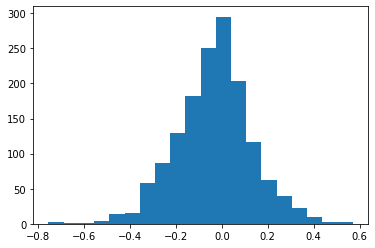

In [ ]:
pylab.hist(-s1f+s2f, bins = 20)

In [ ]:
np.sum(s1f-s2f)/1500

0.03246123617266937

In [ ]:
ns1 = np.array(s1)
ns2 = np.array(s2)
xxx = np.sum(ns1 > ns2)
print(xxx)
yyy = np.sum(ns1 < ns2)
print(yyy)
zzz = np.sum(ns1 == ns2)
print(zzz)

864
617
19


In [ ]:
len(s1)

1500

In [ ]:
sum

NameError: ignored

In [ ]:
x = [1,2,3]
print('\n'.join(map(str, x)))

1
2
3


0.35760860600116273

0.3508676914905399 (beam 0)

0.36784570422204343 (beam 1)

0.445131941036839 (smt)

word2word 0.337865649065229 (nen dung ket qua cu cho thong nhat)

bpe2bpe 0.3677826479020239 (nen dung ket qua cu cho thong nhat)

bpe2bpe all features 0.40819892374214767

bpe2bpe decomposing 0.44710190616016554

word2word decomposing 0.45646605637728693



In [ ]:
print(f'{model.name}  {cb}') #word01001110word.model  0.4588935187948537 0.45646605637728693

word01001110word.model  0.45646605637728693


In [ ]:
!head pred_word10000001word.add.model.vi

**ru_word5input_features, vi_word**

BLEU scores 0.3904458228518665

**ru_word 4without_source, vi_word**

BLEU scores 0.4189770753461321

**subword_all6input_features**

BLEU scores 0.38121640766613113

**ru:word with all features, vi: word**

BLEU scores 0.3898409604570488

**ru:word with all features, vi: syllable**

BLEU scores 0.38041187275465776

**pred_ru_bpe_with_all_features_vi_unigram**

BLEU scores 0.3585956366346239

**pred_ru_unigram_with_all_features_vi_unigram**

BLEU scores 0.37430989535380627

##Subword

In [ ]:
import sentencepiece as spm

In [ ]:
ru_subword = Subword('ru', 4000)
ru_subword.split_words('train.ru', 'train.unigram.ru')
ru_subword.split_words('dev.ru', 'dev.unigram.ru')
ru_subword.split_words('test.ru', 'test.unigram.ru')

vi_subword = Subword('vi', 2000)
vi_subword.split_words('train.vi', 'train.unigram.vi')
vi_subword.split_words('dev.vi', 'dev.unigram.vi')
vi_subword.split_words('test.vi', 'test.unigram.vi')

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 8.6MB/s 


In [ ]:
!pip install subword-nmt

In [ ]:
test_ru_data = pd.read_csv('test.tsv', sep='\t')['ru'].to_list()
dev_ru_data = pd.read_csv('dev.tsv', sep='\t')['ru'].to_list()
train_ru_data = pd.read_csv('train.tsv', sep='\t')['ru'].to_list()

test_vi_data = pd.read_csv('test.tsv', sep='\t')['vi'].to_list()
dev_vi_data = pd.read_csv('dev.tsv', sep='\t')['vi'].to_list()
train_vi_data = pd.read_csv('train.tsv', sep='\t')['vi'].to_list()

In [ ]:
open('test.ru', 'w').write('\n'.join(test_ru_data))
open('dev.ru', 'w').write('\n'.join(dev_ru_data))
open('train.ru', 'w').write('\n'.join(train_ru_data))

2957774

In [ ]:
open('__test.vi', 'w').write('\n'.join(test_vi_data))
open('__dev.vi', 'w').write('\n'.join(dev_vi_data))
open('__train.vi', 'w').write('\n'.join(train_vi_data))

2957774

In [ ]:
detokenize('__test.vi', 'test.vi')
detokenize('__dev.vi', 'dev.vi')
detokenize('__train.vi', 'train.vi')

In [ ]:
%%shell
subword-nmt learn-bpe -s 10000 < train.ru > ru.bpe

In [ ]:
!subword-nmt learn-bpe -s 1500 < train.vi > vi.bpe

In [ ]:
%%shell
subword-nmt apply-bpe -c ru.bpe < test.ru > test.bpe.ru
subword-nmt apply-bpe -c ru.bpe < dev.ru > dev.bpe.ru
subword-nmt apply-bpe -c ru.bpe < train.ru > train.bpe.ru

In [ ]:
%%shell
subword-nmt apply-bpe -c vi.bpe < test.vi > test.bpe.vi
subword-nmt apply-bpe -c vi.bpe < dev.vi > dev.bpe.vi
subword-nmt apply-bpe -c vi.bpe < train.vi > train.bpe.vi

In [ ]:
!subword-nmt apply-bpe -c vi.bpe < test.vi > test.bpe.vi

In [ ]:
!head test.bpe.vi

thiên tài của i@@ o@@ n@@ es@@ c@@ o là khả năng mô tả một thế giới trong đó điều phi lý chiến thắng . 
tất cả đều kêu gọi hành động chính trị chung , ng@@ ụ ý sự cần thiết phải đàm phán với t@@ al@@ i@@ ban . 
phản ứng trước sự gây h@@ ấn ban đầu của h@@ e@@ z@@ bo@@ l@@ la@@ h , cũng như hành động quân sự trả đ@@ ũ@@ a của israel ở gaza , rất khắc ngh@@ iệt . 
cùng với các trường hợp tương tự khác , các vụ kiện này đặt ra những câu hỏi nghiêm trọng về hệ thống tư pháp của ukraine và các cơ quan thực thi pháp luật . 
không có nghi ngờ rằng d@@ a@@ ch đã vi phạm quyền của hàng ng@@ àn người kh@@ me@@ r . 
để trở về mức độ việc làm trước khi suy thoái kinh tế mỹ , cần hơn 11 triệu việc làm mới . 
nhưng trong trường hợp này , chúng tôi đã quá b@@ ận tâm với tình hình hiện tại đến nỗi chúng tôi đã vượt qua mọi khác biệt . 
sau chiến thắng của al@@ l@@ en@@ de , thị trường chứng khoán và thị trường ch@@ il@@ e đã bị k@@ ìm hã@@ m bởi sự hoảng loạn tài chính . 
nếu bạn không nhìn thấy phẩm 

In [ ]:
testsent = 'thiên tài của i@@ o@@ n@@ es@@ c@@ o là khả năng mô tả một thế giới trong đó điều phi lý chiến thắng .'
testsent.replace('@@ ','')

'thiên tài của ionesco là khả năng mô tả một thế giới trong đó điều phi lý chiến thắng .'

In [ ]:
vi_data = pd.read_csv('vi.tsv', sep='\t')
vi_data.columns

Index(['unigram', 'syllable', 'word'], dtype='object')

In [ ]:
vi_bpe = open('test.bpe.vi','r').read().splitlines() + open('dev.bpe.vi','r').read().splitlines() + open('train.bpe.vi','r').read().splitlines()
vi_data['bpe'] = vi_bpe
vi_data = vi_data[['bpe','unigram', 'syllable', 'word']]
vi_data.to_csv('new.vi.tsv', sep='\t', index=False)

In [ ]:
def tag_subword(bpe_filename, factor_filename, outfilename):
    """
    function tags subwords
    input: bpe_filename, bpe.ru file,
    input: factor_filename, tsv file
    output: outfilename, tsv file

    """
     
    bpe_sentences = open(bpe_filename, 'r').read().splitlines()
    factor_names = ['le', 'ihead', 'head', 'deprel', 'upos', 'feats']
    factor_sequences = pd.read_csv(factor_filename, sep='\t')

    trgs = factor_sequences['vi']
    factor_sequences = factor_sequences[factor_names]

    bpeNfactor_sentences = []

    j = 0

    for sentence in bpe_sentences:
        factor_sequence = factor_sequences.iloc[j].to_list()
        factor_sequence = [e.split(' ') for e in factor_sequence]
        factor_sequence = pd.DataFrame(data=factor_sequence)
        state = "O"
        i = 0
        tag_sentence = []
        
        for word in sentence.split():
            factors = factor_sequence.iloc[:,i].to_list()
            if word.endswith('@@'):
                if state == "O" or state == "E":
                    state = "B"
                elif state == "B" or state == "I":
                    state = "I"
            else:
                i += 1
                if state == "B" or state == "I":
                    state = "E"
                else:
                    state = "O"
            tag_sentence.append([word, state] + factors)
        
        tag_sequence = pd.DataFrame(columns=['ru','subtag']+ factor_names, data=tag_sentence)
        tag_sequence = [tag_sequence[factor].str.cat(sep=' ') for factor in tag_sequence]
        bpeNfactor_sentences.append(tag_sequence)

        j += 1
    result = pd.DataFrame(columns=['ru','subtag']+ factor_names, data=bpeNfactor_sentences)
    result['vi'] = trgs 
    result.to_csv(outfilename, sep='\t',index=False)

tag_subword('test.bpe.ru', 'test.tsv', 'test.sub.tsv')
tag_subword('dev.bpe.ru', 'dev.tsv', 'dev.sub.tsv')
tag_subword('train.bpe.ru', 'train.tsv', 'train.sub.tsv')

In [ ]:
def tag_unigram_subword(unigram_filename, factor_filename, outfilename):
    """
    function tags subwords
    input: unigram_filename, unigram.ru file,
    input: factor_filename, tsv file
    output: outfilename, tsv file

    """
    
    unigram_sentences = open(unigram_filename, 'r').read().splitlines()
    factor_names = ['le', 'ihead', 'head', 'deprel', 'upos', 'feats']
    factor_sequences = pd.read_csv(factor_filename, sep='\t')

    factor_sequences = factor_sequences[factor_names]

    unigramNfactor_sentences = []

    j = 0

    for sentence in unigram_sentences:
        factor_sequence = factor_sequences.iloc[j].to_list()
        factor_sequence = [e.split(' ') for e in factor_sequence]
        factor_sequence = pd.DataFrame(data=factor_sequence)
        #print(factor_sequence.shape)
        state = "O"
        i = 0
        tag_sentence = []

        # print(f"The number of '▁' is {sentence.count('▁')}")
        # print(f"The number of whole words is {factor_sequence.shape[1]}")
        # print('    ')
        
        words = sentence.split()
        for k, word in enumerate(words[:-1]):
            #print(i)
            factors = factor_sequence.iloc[:,i].to_list()
            if len(factors) < 6:
                print()
            
            if word.startswith('▁'):
                if words[k+1].startswith('▁'):
                    state = "O"
                    i += 1
                else:
                    state = "B"
            else:
                if words[k+1].startswith('▁'):
                    state == "E"
                    i += 1
                else:
                    state = "I"
                
            tag_sentence.append([word, state] + factors)
        
        if words[-1].startswith('▁'):
            state = "O"
        else:
            state = "E"
        factors = factor_sequence.iloc[:,-1].to_list()
        tag_sentence.append([words[-1], state] + factors)


        tag_sequence = pd.DataFrame(columns=['ru','subtag']+ factor_names, data=tag_sentence)
        tag_sequence = [tag_sequence[factor].str.cat(sep=' ') for factor in tag_sequence]
        unigramNfactor_sentences.append(tag_sequence)

        j += 1
    result = pd.DataFrame(columns=['ru','subtag']+ factor_names, data=unigramNfactor_sentences)
    result.to_csv(outfilename, sep='\t',index=False)

tag_unigram_subword('dev.unigram.ru', 'dev.tsv', 'dev.unigram.ru.tsv')
tag_unigram_subword('train.unigram.ru', 'train.tsv', 'train.unigram.ru.tsv')
tag_unigram_subword('test.unigram.ru', 'test.tsv', 'test.unigram.ru.tsv')

IndentationError: ignored

In [ ]:
test_unigram_ru = pd.read_csv('test.unigram.ru.tsv', sep='\t')
dev_unigram_ru = pd.read_csv('dev.unigram.ru.tsv', sep='\t')
train_unigram_ru = pd.read_csv('train.unigram.ru.tsv', sep='\t')
unigram_ru = pd.concat([test_unigram_ru, dev_unigram_ru, train_unigram_ru])
unigram_ru.to_csv('unigram.ru.tsv', sep='\t', index=False)

In [ ]:
x = pd.read_csv('unigram.ru.tsv', sep='\t')

In [ ]:
x.columns

Index(['ru', 'subtag', 'le', 'ihead', 'head', 'deprel', 'upos', 'feats'], dtype='object')

In [ ]:
x.iloc[0,:]

ru        ▁ген и ально сть ▁и он е ско ▁заключал ась ▁в ...
subtag    B I I I B I I I B B O B B B B O O O B B B I I O O
le        гениальность гениальность гениальность гениаль...
ihead     3 3 3 3 3 3 3 3 0 0 5 3 3 5 5 6 11 10 11 11 7 ...
head      заключаться заключаться заключаться заключатьс...
deprel    nsubj nsubj nsubj nsubj advmod advmod advmod a...
upos      NOUN NOUN NOUN NOUN ADV ADV ADV ADV VERB VERB ...
feats     Animacy=Inan,Case=Nom,Gender=Fem,Number=Sing A...
Name: 0, dtype: object

##Factor

In [ ]:
# !pip install stanza
if factored:
    import stanza
    stanza.download('ru')
    nlp = stanza.Pipeline(lang='ru', processors='tokenize,mwt,pos,lemma,depparse')
    def __words2factors(sentence, nlp=nlp):
        doc = nlp(sentence)
        result = [# ' '.join([word.lemma for sent in doc.sentences for word in sent.words]),
                ' '.join([str(word.head) for sent in doc.sentences for word in sent.words]),
                ' '.join([sent.words[word.head-1].lemma for sent in doc.sentences for word in sent.words]),
                ' '.join([word.deprel for sent in doc.sentences for word in sent.words]),
                ' '.join([word.upos for sent in doc.sentences for word in sent.words]),
                ' '.join([word.feats if word.feats else "_" for sent in doc.sentences for word in sent.words]).replace('|', ',')]
        return result


    def words2factors(filename, newfilename):
        data = pd.read_csv(filename, sep='\t')
        features = [__words2factors(line) for line in data['ru']]
        features = pd.DataFrame(columns=['ihead', 'head', 'deprel', 'upos', 'feats'], data=features)
        x = data.join(features)
        x = x[['ru', 'le', 'ihead', 'head', 'deprel', 'upos', 'feats', 'vi']]
        x.to_csv(newfilename, sep='\t', index=False)

    start_time = time.time()
    words2factors('dev.RuLeVi.tsv', 'dev.tsv')
    print('...dev')
    words2factors('test.RuLeVi.tsv', 'test.tsv')
    print('...test')
    words2factors('train.RuLeVi.tsv', 'train.tsv')
    end_time = time.time()        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'time in minutes: {epoch_mins}')

    

In [ ]:
!pip install stanza

     |████████████████████████████████| 194kB 2.8MB/s 


In [ ]:
import stanza
stanza.download('vi')

2020-06-18 07:38:24 INFO: Downloading default packages for language: vi (Vietnamese)...
2020-06-18 07:38:42 INFO: Finished downloading models and saved to /root/stanza_resources.


In [ ]:
nlp = stanza.Pipeline(lang='vi', processors='tokenize,pos,lemma,depparse')
sentence = 'khắp châu phi , trung quốc đang tài trợ và xây dựng cơ sở hạ tầng cơ bản . đầu tư vào giáo dục là vấn đề sống còn đối với mỹ latinh và caribê .'
doc = nlp(sentence)
print(doc)

In [ ]:
doc.sentences[1]

In [ ]:
nlp = stanza.Pipeline(lang='vi', processors='tokenize,pos,ner')
sentence = 'đầu tư vào giáo dục là vấn đề sống còn đối với mỹ latinh và caribê .'
doc = nlp(sentence)
print(doc)

In [ ]:
# !pip install stanza
import stanza
stanza.download('vi')
nlp = stanza.Pipeline(lang='vi', processors='tokenize,mwt,pos,lemma,depparse,ner')
sentence = 'đầu tư vào giáo dục là vấn đề sống còn đối với mỹ latinh và caribê .'
doc = nlp(sentence)

def __words2factors(sentence, nlp=nlp):
    doc = nlp(sentence)
    result = [# ' '.join([word.lemma for sent in doc.sentences for word in sent.words]),
            ' '.join([str(word.head) for sent in doc.sentences for word in sent.words]),
            ' '.join([sent.words[word.head-1].lemma for sent in doc.sentences for word in sent.words]),
            ' '.join([word.deprel for sent in doc.sentences for word in sent.words]),
            ' '.join([word.upos for sent in doc.sentences for word in sent.words]),
            ' '.join([word.feats if word.feats else "_" for sent in doc.sentences for word in sent.words]).replace('|', ',')]
    return result


def words2factors(filename, newfilename):
    data = pd.read_csv(filename, sep='\t')
    features = [__words2factors(line) for line in data['ru']]
    features = pd.DataFrame(columns=['ihead', 'head', 'deprel', 'upos', 'feats'], data=features)
    x = data.join(features)
    x = x[['ru', 'le', 'ihead', 'head', 'deprel', 'upos', 'feats', 'vi']]
    x.to_csv(newfilename, sep='\t', index=False)

start_time = time.time()
words2factors('dev.RuLeVi.tsv', 'dev.tsv')
print('...dev')
words2factors('test.RuLeVi.tsv', 'test.tsv')
print('...test')
words2factors('train.RuLeVi.tsv', 'train.tsv')
end_time = time.time()        
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'time in minutes: {epoch_mins}')

In [ ]:
%%shell
cd /content
git clone https://github.com/vncorenlp/VnCoreNLP.git

Cloning into 'VnCoreNLP'...
remote: Enumerating objects: 212, done.
remote: Total 212 (delta 0), reused 0 (delta 0), pack-reused 212
Receiving objects: 100% (212/212), 214.21 MiB | 13.54 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [ ]:
!pip install vncorenlp

     |████████████████████████████████| 2.7MB 2.8MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-cp36-none-any.whl size=2645935 sha256=6ab59249a9643afbf18ae2312f18c44aa3a5bb894b880e5583136a786a011cd9
  Stored in directory: /root/.cache/pip/wheels/09/54/8b/043667de6091d06a381d7745f44174504a9a4a56ecc9380c54
Successfully built vncorenlp


In [ ]:
from vncorenlp import VnCoreNLP
annotator = VnCoreNLP("/content/VnCoreNLP/VnCoreNLP-1.1.1.jar", annotators="wseg,pos,ner,parse", max_heap_size='-Xmx2g') 

# Input 
# text = "Ông Nguyễn Khắc Chúc  đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây."
# To perform word segmentation, POS tagging, NER and then dependency parsing
# annotated_text = annotator.annotate(text)

# To perform word segmentation only
# word_segmented_text = annotator.tokenize(text) 

In [ ]:
text = "Ông Nguyễn Khắc Chúc  đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây."
text = 'điện Kremlin đã làm_ngơ trước sự ân_xá của Kadyrov , đối_với các cựu_chiến_binh và việc đưa họ vào lực_lượng dân_quân .'
text = 'khắp châu phi , trung quốc đang tài trợ và xây dựng cơ sở hạ tầng cơ bản .'
text = 'đầu tư vào giáo dục là vấn đề sống còn đối với mỹ latinh và caribê .'
word_segmented_text = annotator.tokenize(text)
annotated_text = annotator.annotate(text)
print(word_segmented_text)
print(annotated_text)

[['đầu_tư', 'vào', 'giáo_dục', 'là', 'vấn_đề', 'sống_còn', 'đối_với', 'mỹ', 'latinh', 'và', 'caribê', '.']]
{'sentences': [[{'index': 1, 'form': 'đầu_tư', 'posTag': 'V', 'nerLabel': 'O', 'head': 0, 'depLabel': 'root'}, {'index': 2, 'form': 'vào', 'posTag': 'E', 'nerLabel': 'O', 'head': 1, 'depLabel': 'loc'}, {'index': 3, 'form': 'giáo_dục', 'posTag': 'N', 'nerLabel': 'O', 'head': 2, 'depLabel': 'pob'}, {'index': 4, 'form': 'là', 'posTag': 'V', 'nerLabel': 'O', 'head': 1, 'depLabel': 'vmod'}, {'index': 5, 'form': 'vấn_đề', 'posTag': 'N', 'nerLabel': 'O', 'head': 4, 'depLabel': 'vmod'}, {'index': 6, 'form': 'sống_còn', 'posTag': 'V', 'nerLabel': 'O', 'head': 5, 'depLabel': 'nmod'}, {'index': 7, 'form': 'đối_với', 'posTag': 'E', 'nerLabel': 'O', 'head': 5, 'depLabel': 'nmod'}, {'index': 8, 'form': 'mỹ', 'posTag': 'N', 'nerLabel': 'O', 'head': 7, 'depLabel': 'pob'}, {'index': 9, 'form': 'latinh', 'posTag': 'N', 'nerLabel': 'O', 'head': 8, 'depLabel': 'nmod'}, {'index': 10, 'form': 'và', 'p

In [ ]:
test = pd.read_csv('test.tsv', sep='\t')
dev = pd.read_csv('dev.tsv', sep='\t')
train = pd.read_csv('train.tsv', sep='\t')
data = pd.concat([test, dev, train])[['ru', 'le', 'ihead', 'head', 'deprel', 'upos', 'feats']]
data.to_csv('word.ru.tsv', sep='\t', index=False)

In [ ]:
data.columns

Index(['ru', 'le', 'ihead', 'head', 'deprel', 'upos', 'feats', 'vi'], dtype='object')

In [ ]:
data.shape

(33027, 8)

In [ ]:
data.columns

Index(['ru', 'le', 'ihead', 'head', 'deprel', 'upos', 'feats', 'vi'], dtype='object')

In [ ]:
bpe_test = pd.read_csv('test.sub.tsv', sep='\t')
bpe_dev = pd.read_csv('dev.sub.tsv', sep='\t')
bpe_train = pd.read_csv('train.sub.tsv', sep='\t')
bpe_data = pd.concat([bpe_test, bpe_dev, bpe_train])

In [ ]:
bpe_data = bpe_data[['ru', 'subtag', 'le', 'ihead', 'head', 'deprel', 'upos', 'feats']]

In [ ]:
bpe_data.to_csv('bpe.ru.tsv', sep='\t', index=False)

In [ ]:
bpe_data.iloc[0,:]

ru        г@@ ени@@ аль@@ ность и@@ о@@ нес@@ ко заключа...
subtag          B I I E B I I E O O O B E O O O O B E B E O
le        гениальность гениальность гениальность гениаль...
ihead      3 3 3 3 3 3 3 3 0 5 3 5 5 6 11 10 11 7 7 11 11 3
head      заключаться заключаться заключаться заключатьс...
deprel    nsubj nsubj nsubj nsubj advmod advmod advmod a...
upos      NOUN NOUN NOUN NOUN ADV ADV ADV ADV VERB ADP N...
feats     Animacy=Inan,Case=Nom,Gender=Fem,Number=Sing A...
Name: 0, dtype: object

In [ ]:
x = open('test.unigram.vi', 'r').read().splitlines()
y = open('dev.unigram.vi', 'r').read().splitlines()
z = open('train.unigram.vi', 'r').read().splitlines()
xyz = x + y + z

x = open('test.vi', 'r').read().splitlines()
y = open('dev.vi', 'r').read().splitlines()
z = open('train.vi', 'r').read().splitlines()
xyz1 = x + y + z

x = open('__test.vi', 'r').read().splitlines()
y = open('__dev.vi', 'r').read().splitlines()
z = open('__train.vi', 'r').read().splitlines()
xyz2 = x + y + z

pd.DataFrame({'unigram':xyz, 'syllable': xyz1, 'word': xyz2}).to_csv('vi.tsv', sep='\t', index=False)

In [ ]:
vi = pd.read_csv('vi.tsv', sep='\t')

In [ ]:
vi.shape

(33027, 3)

In [ ]:
ruvi_dict = defaultdict(lambda : '<unk>')
ruvi_prob = defaultdict(lambda : 0.0)
e2f = open('lex.e2f', 'r').read().splitlines()
for line in e2f:
    ruword, viword, value = line.split(' ')
    fvalue = float(value)
    if fvalue > ruvi_prob[ruword]:
        ruvi_dict[ruword] = viword
        ruvi_prob[ruword] = fvalue

In [ ]:
ru_data = pd.read_csv('word.nowordtranslation.ru.tsv', sep='\t')
ru_sentences = ru_data['ru'].to_list()
ru_words = [sentence.split(' ') for sentence in ru_sentences]
vi_words = [[ruvi_dict[word] for word in sentence] for sentence in ru_words]
vi_sentences = [' '.join(sentence) for sentence in vi_words]

columns = list(ru_data.columns)
ru_data['wordtranslation'] = vi_sentences
ru_data = ru_data[columns + ['wordtranslation']]
ru_data.to_csv('word.ru.tsv', sep='\t', index=False)

In [ ]:
import pickle
with open('ruvi_dict.pickle', 'wb') as handle:
    pickle.dump(ruvi_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('ruvi_dict.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
list(ruvi_dict.keys())[:5]

['потенциальных', 'диаса', 'саммитах', 'проигнорированы', '1989']

In [ ]:
list(b.keys())[:5]

['потенциальных', 'диаса', 'саммитах', 'проигнорированы', '1989']

In [ ]:
b['саммитах']

'hội_nghị_thượng_đỉnh'

In [ ]:
allru = pd.read_csv('word.ru.tsv', sep='\t')

In [ ]:
len(allru.columns)

8

In [ ]:
!head __train.vi

SMT

In [ ]:
subprocess.run(['unzip', '/content/gdrive/My Drive/tools/smt.zip', '-d', '/'])
subprocess.run(['unzip', '/content/gdrive/My Drive/tools/mgiza.zip', '-d', '/'])

CompletedProcess(args=['unzip', '/content/gdrive/My Drive/tools/mgiza.zip', '-d', '/'], returncode=0)

In [ ]:
pwd

'/content/gdrive/My Drive/nmt_models/NewsLinguisticFeaturesALL'

In [ ]:
!unzip smt_result.zip -d /

In [ ]:
!zcat /content/working/train/model/phrase-table.gz > phrase-table.txt

In [ ]:
!head -500 phrase-table.txt

In [ ]:
pt = open('phrase-table.txt', 'r').read().splitlines()
wpt = open('word-phrase-table.txt', 'w')
for line in pt:
    parts = line.split(' ||| ')
    ru, vi = parts[0], parts[1]
    #print(parts[2])
    score = float(parts[2].split(' ')[2])
    if len(parts[0].split(' ')) == 1:
        wpt.write(f'{ru} ||| {vi} ||| {score} \n')
wpt.close()



In [ ]:
!cat word-phrase-table.txt

In [ ]:
float('2.50465e-11')

2.50465e-11

In [ ]:
!zcat /content/working/train/model/extract.sorted.gz | tail -500

In [ ]:
%%shell
cd /content/working/
/content/tools/moses/bin/moses -f /content/working/mert-work/moses.ini < test.ru > __pred_test.smt.vi 2> test.out

In [ ]:
DataCenter.detokenize('/content/working/__pred_test.smt.vi', '/content/working/pred_test.smt.vi')

In [ ]:
def evaluate_bleu_nltk(reference_filename, hypothesis_filename):
    references = open(reference_filename).read().splitlines()
    references = [line.split(' ') for line in references]
    hypotheses = open(hypothesis_filename, 'r').read().splitlines()
    hypotheses = [line.split(' ') for line in hypotheses]

    list_refs = [[r] for r in references]

    return corpus_bleu(list_refs, hypotheses)

#cb = evaluate_bleu_nltk(reference_filename='test.vi', 
#                        hypothesis_filename=f'pred_{model.name}.vi')
cb = evaluate_bleu_nltk(reference_filename='test.vi', 
                        hypothesis_filename='/content/working/pred_test.smt.vi')
print(cb)

0.445131941036839


In [ ]:
!head '/content/working/pred_test.smt.vi'

In [ ]:
!mkdir /content/working

In [ ]:
cd /content/working

/content/working


In [ ]:
!cp /content/gdrive/My\ Drive/nmt_models/NewsLinguisticFeaturesALL/train.ru /content/gdrive/My\ Drive/nmt_models/NewsLinguisticFeaturesALL/__train.vi /content/working/

In [ ]:
!cp /content/gdrive/My\ Drive/nmt_models/NewsLinguisticFeaturesALL/dev.ru /content/gdrive/My\ Drive/nmt_models/NewsLinguisticFeaturesALL/__dev.vi /content/working/

In [ ]:
!head /content/gdrive/My\ Drive/nmt_models/NewsLinguisticFeaturesALL/__train.vi

In [ ]:
!ls /content/working/

dev.ru	  train		   __train.blm.vi  __train.vi
__dev.vi  __train.arpa.vi  __train.ru


In [ ]:
import subprocess
subprocess.run(['unzip', '/content/gdrive/My Drive/tools/smt.zip', '-d', '/'])
subprocess.run(['unzip', '/content/gdrive/My Drive/tools/mgiza.zip', '-d', '/'])

CompletedProcess(args=['unzip', '/content/gdrive/My Drive/tools/mgiza.zip', '-d', '/'], returncode=0)

In [ ]:
#Language Model Training
!/content/tools/moses/bin/lmplz -o 3 < __train.vi > __train.arpa.vi

In [ ]:
#binarise (for faster loading)
!/content/tools/moses/bin/build_binary __train.arpa.vi __train.blm.vi

In [ ]:
#Training the Translation System
!/content/tools/moses/scripts/training/train-model.perl -mgiza -root-dir train -corpus __train -f ru -e vi -alignment grow-diag-final-and -reordering msd-bidirectional-fe -lm 0:3:/content/working/__train.blm.vi:8 -external-bin-dir /content/mgiza/mgizapp/inst

In [ ]:
%%shell
cd /content/working
/content/tools/moses/scripts/training/mert-moses.pl dev.ru __dev.vi /content/tools/moses/bin/moses train/model/moses.ini --mertdir /content/tools/moses/bin --decoder-flags="-threads 4" &> mert.out

In [ ]:
%%shell
cd /content
zip -r smt_result.zip /content/working
cp /content/smt_result.zip /content/gdrive/My\ Drive/nmt_models/NewsLinguisticFeaturesALL

In [ ]:
import pandas as pd
bpeRU = pd.read_csv('bpe.ru.tsv', sep='\t')

In [ ]:
bpeRU = pd.read_csv('bpe.ru.tsv', sep='\t')

In [ ]:
bpeRU['ru'].iloc[2]

'ответ на первонача@@ льную а@@ гре@@ сси@@ ю хезбол@@ лы , как и ответ@@ ные военные действия израиля в га@@ зе являются не@@ пропорциональ@@ но суро@@ выми .'

In [ ]:
unigramRU = pd.read_csv('unigram.ru.tsv', sep='\t')

In [ ]:
unigramRU['ru'].iloc[2]

'▁ответ ▁на ▁первоначальн ую ▁агресси ю ▁хезболл ы ▁, ▁как ▁и ▁ответ ные ▁военны е ▁действия ▁израил я ▁в ▁газ е ▁являются ▁не про пор ц и он ально ▁с у ров ыми ▁.'

In [ ]:
VI = pd.read_csv('new.vi.tsv', sep='\t')

In [ ]:
VI.columns

Index(['bpe', 'unigram', 'syllable', 'word'], dtype='object')

In [ ]:
VI['bpe'].iloc[2]

'phản ứng trước sự gây h@@ ấn ban đầu của h@@ e@@ z@@ bo@@ l@@ la@@ h , cũng như hành động quân sự trả đ@@ ũ@@ a của israel ở gaza , rất khắc ngh@@ iệt . '